# Proyecto $wCDM$

https://github.com/Michicol/Proyecto-wCDM/blob/main/Proyecto%202%20wCDM.pdf

In [1]:
#se habilitan solo si se trbaja en drive
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#import os
#import sys

In [3]:
#path = '/content/drive/MyDrive/Proyecto LCDM/'
#sys.path.append(path)

In [4]:
#!pip install astropy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 78.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 79.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 738.7/738.7 kB 47.8 MB/s eta 0:00:00


In [5]:
#!pip install numba

In [1]:
from metodos.EDO import EDO
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.integrate import quad
import scipy.constants as con
import pandas as pd
from numba import jit

plt.style.use('ggplot')

In [2]:
def friedmann(a, t, params):
    omega_co, omega_ro = params
    omega_Ao = 1 - omega_co - omega_ro
    return a * np.sqrt(omega_co * a**(-3) + omega_ro * a**(-4) + omega_Ao)

In [3]:
type(con.c)

float

In [4]:
t_i = 1e-10
t_f = 2
t_valores = np.linspace(t_i,t_f,1000)
omega_co = 0.3
omega_ro = 0
a_i = 1

In [5]:
a_valores = EDO.rk4Solve(friedmann,[a_i],t_valores,(omega_co,omega_ro))

(0.0, 1.5)

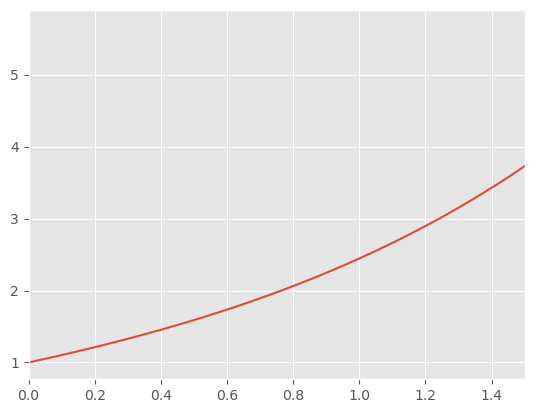

In [6]:
plt.plot(t_valores,a_valores)
plt.xlim(0,1.5)

In [7]:
def Hubble_Time(H0):
    yr=365*24*60*60
    seg=1./yr # un segundo en años
    seg=seg*1e-9 # un segundo en Giga-años
    Mpc=con.parsec*1e6*1e-3 ## parsec a metros y luego a kilometros
    H0_s=H0/Mpc  # H0 a 1/s
    t=1./H0_s # tiempo de Hubble en segundos
    t=t*seg # " " en Giga-años
    return t

In [8]:
def h(z, Ω_dm, Ω_l, w_l, H0):
    # Ecuación de Hubble modificada
    Ω_r =  8.5e-5
    H_squared = (
        Ω_dm * (1 + z)**3 +         # Materia oscura (P=0 ⇒ w=0)
        Ω_r * (1 + z)**4 +          # Radiación (P=ρ/3 ⇒ w=1/3)
        Ω_l * (1 + z)**(3*(1 + w_l)) # Energía oscura (P=w_l*ρ)
    )
    return np.sqrt(np.abs(H_squared))

def integrando(z, Ω_dm, Ω_l, w_l, H0):
    c = con.c * 1e-3
    Hubble_size = c/H0
    return Hubble_size / h(z, Ω_dm, Ω_l, w_l, H0)

def χ(z, Ω_dm, Ω_l, w_l, H0):
    return quad(integrando, 1e-6, z, args=(Ω_dm, Ω_l, w_l, H0))[0]

χ = np.vectorize(χ)

def dL(z, Ω_dm, Ω_l, w_l, H0):
    return (1 + z) * χ(z, Ω_dm, Ω_l, w_l, H0)

def mu(z, Ω_dm, Ω_l, w_l, H0):
    return 5 * np.log10(dL(z, Ω_dm, Ω_l, w_l, H0) * 1e6) - 5

In [9]:
#se cambia en caso de trabajar en colab ejemplo '/content/drive/MyDrive/Proyecto LCDM 2/Proyecto LCDM/SCPUnion2_mu_vs_z.txt'
file = './SCPUnion2_mu_vs_z.txt'

In [10]:
data1 = pd.read_csv(file, skiprows=6, delimiter="\t",header=None,usecols=[1,2,3])
data1.columns=['$z$','$\mu$','$\sigma_\mu$']

## Determinación de los parámetros iniciales para las cadenas de Markov

In [11]:
from scipy.optimize import least_squares

In [12]:
def h(z, Ω_dm, Ω_l, w_l, H0):
    # Ecuación de Hubble modificada
    Ω_r =  0
    H_squared = (
        Ω_dm * (1 + z)**3 +         # Materia oscura (P=0 ⇒ w=0)
        Ω_r * (1 + z)**4 +          # Radiación (P=ρ/3 ⇒ w=1/3)
        Ω_l * (1 + z)**(3*(1 + w_l)) # Energía oscura (P=w_l*ρ)
    )
    return np.sqrt(np.abs(H_squared))

In [13]:
z = data1['$z$'].values
mu_data = data1['$\mu$'].values
mu_err = data1['$\sigma_\mu$'].values

In [14]:
def m_rel(z,theta=[0.3,0.7,-1,70]): # en realidad esto corresponde a la magnitud relativa: f= mu + M
    # Sin embargo, para dejar a M como parametro libre conviene incluirlo en esta funcion y no en la expresion para mu_obs
    return 5*np.log10(((10**6)*dL(z,theta[0],theta[1],theta[2],theta[3]))/1)-5#+M

m_rel = np.vectorize(m_rel,excluded = [1])

# function that calculates residuals based on a given theta
def ode_model_resid(theta=[0.3,0.7,-1,70]):
    return mu_data - m_rel(z, theta)

In [15]:
theta = [0.3,0.7,-1,70]
results = least_squares(ode_model_resid, x0=theta)

/tmp/ipykernel_3782/711318861.py:17: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return quad(integrando, 1e-6, z, args=(Ω_dm, Ω_l, w_l, H0))[0]
/tmp/ipykernel_3782/711318861.py:17: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  return quad(integrando, 1e-6, z, args=(Ω_dm, Ω_l, w_l, H0))[0]


In [16]:
ResParam = pd.DataFrame()
parametros_n = ['Om','Ol','wl','H0']
ResParam['Parametros'] = parametros_n
ResParam['Solución por Minimos Cuadrados'] = results.x
print(ResParam.round(3))

  Parametros  Solución por Minimos Cuadrados
0         Om                           0.443
1         Ol                           0.583
2         wl                          -1.874
3         H0                          69.782


## Variacion de los parametros de $\Omega_m$ y  $\Omega_l$ con $\omega = -1$ fija

<Figure size 640x480 with 0 Axes>

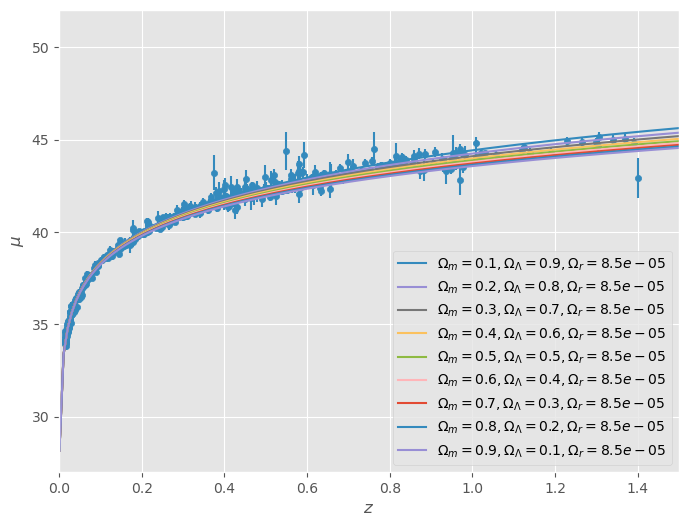

In [17]:
z = np.linspace(0.001, 10,  1000)

Ωm = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
Ωl = [0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1]
label = ['$\Omega_m={},\Omega_\Lambda={},\Omega_r = {}$'.format(om,ol,8.5e-5) for om,ol in zip(Ωm,Ωl)]


fig=plt.figure()
data1.plot(x='$z$', y='$\mu$', yerr='$\sigma_\mu$', kind='scatter',figsize=(8,6))
[plt.plot(z,mu(z,Ωm[i],Ωl[i],-1,70),label=label[i]) for i in range(9)]

plt.xlim(0,1.5)
plt.xlabel('$z$')
plt.ylabel('$\mu$')
plt.legend()
plt.grid(True)
plt.show()

<Figure size 640x480 with 0 Axes>

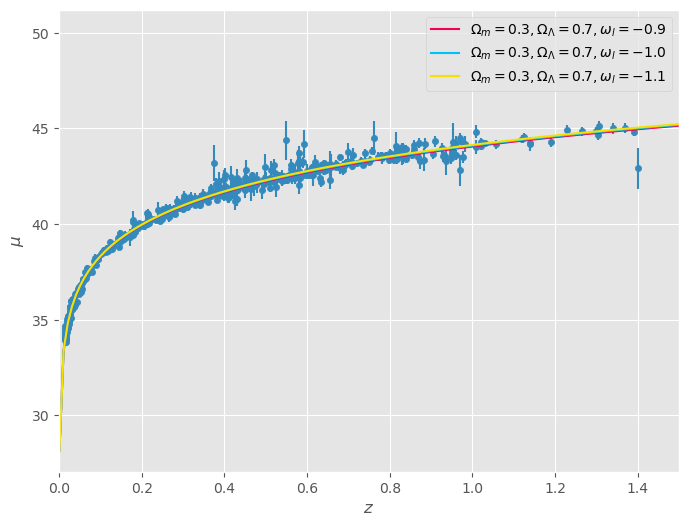

In [18]:
z = np.linspace(0.001, 10,  1000)

Ωm = 0.3
Ωl = 0.7
wl = [-0.9,-1.,-1.1]
color = ['#F50055','#00C3F5','#F5E000']

label = ['$\Omega_m={},\Omega_\Lambda={},\omega_l={}$'.format(Ωm,Ωl,wl[i]) for i in range(3)]


fig=plt.figure()
data1.plot(x='$z$', y='$\mu$', yerr='$\sigma_\mu$', kind='scatter',figsize=(8,6))
[plt.plot(z,mu(z,Ωm,Ωl,wl[i],70),label=label[i],color=color[i]) for i in range(3)]

plt.xlim(0,1.5)
plt.xlabel('$z$')
plt.ylabel('$\mu$')
plt.legend()
plt.grid(True)
plt.show()

## Implementación del algoritmo de Metropolis-Hastings para la generación de las cadenas de Markov

In [19]:
def PoissonLikelihood(dat, model_prediction):
    loglike=0.0
    for x, L in zip(dat, model_prediction):
        if(L>0.0):
            loglike = loglike - L + x*np.log(L)
    return loglike

def GaussianLikelihood(x_dat,x_teoria,sigma_d):
    return np.sum(-(x_dat-x_teoria)**2/(2*sigma_d**2))

In [20]:
z = data1['$z$'].values
mu_data = data1['$\mu$'].values
mu_err = data1['$\sigma_\mu$'].values

In [21]:
Om_min= 0.
Om_max= 1.

Ol_min = 0.
Ol_max = 1.

H0_min= 50.
H0_max= 100.

In [22]:
Om = 0.3
Ol = 0.2
H0 = 70

In [23]:
sigma_Om = 0.05
sigma_Ol = 0.05
sigma_H0 = 0.3

In [24]:
# Inicialización de variables:
random=0.0
like = 1e-20
loglike=np.log(like)
#Numero total de iteraciones
Number_of_steeps = 1000
#Numero de pasos iniciales antes de truncar la cadena
Burn_in_Time = 20
# Archivo de salida donde se escriben los pasos aceptados
cadena_lcdm = []

In [25]:
for i in range(Number_of_steeps):

    # Escogiendo aleatoriamente un numero x2c de una muestra con distribucion normal (la distribucion propuesta q)


    Om_try=abs(np.random.normal(Om,sigma_Om))


     # Si resulta que el valor del parametro se sale del rango permitido (λ1_min,λ1_max) entonces vuelve
    # a escoger un valor nuevo.
    while (Om_max<Om_try or Om_try<Om_min):
        Om_try=abs(np.random.normal(Om,sigma_Om))

    Ol_try = 1 - Om_try - 8.5e-5


    H0_try=abs(np.random.normal(H0,sigma_H0))
    while  (H0_max<H0_try or H0_try<H0_min):
        H0_try=abs(np.random.normal(H0,sigma_H0))


    #Calculando la prediccion teórica usando la libreria que calcula predicciones teoricas
    mu_theory=mu(z,Om_try,Ol_try,-1,H0_try)

    # Calculando la funcion de verosimilitud o likelihood (Poissoniana) para el punto inicial y los datos
    #loglike_try = PoissonLikelihood(mu_data, mu_theory)
    loglike_try = GaussianLikelihood(mu_data, mu_theory, mu_err)
    #print(loglike_try)
    if(np.isnan(loglike_try)==False):

    #  Calculando la probabilidad de aceptación para el punto de prueba x2c:

        if (loglike_try < loglike and i>0):
            random = np.random.uniform(0.0,1.0)
        # P(D|x2)q(x1|x2)/P(D|x1)q(x2|x1), q es gaussiana (~e^{(x1-x2)^2/sigma^2}) entonces q(x1|x2)=q(x2|x1)
            accepted = np.exp(loglike_try - loglike)
        else:
            accepted = 1.

     # Aqui se está tomando la decisión de si aceptar a x2c con probabilidad uniforme accepted

    if ( random < accepted):
        Om = Om_try
        Ol = Ol_try
        H0 = H0_try

        loglike = loglike_try

        if(i>Burn_in_Time):
            cadena_lcdm.append(np.array([Om,Ol,H0,loglike]))

In [26]:
cadena_lcdm

[array([ 2.54151250e-01,  7.45763750e-01,  7.03663910e+01, -2.71686761e+02]),
 array([ 2.51269582e-01,  7.48645418e-01,  7.00426602e+01, -2.71996514e+02]),
 array([ 2.46595929e-01,  7.53319071e-01,  7.02033144e+01, -2.71979261e+02]),
 array([ 2.34570002e-01,  7.65344998e-01,  7.05881261e+01, -2.72920261e+02]),
 array([ 2.57275649e-01,  7.42639351e-01,  7.05960018e+01, -2.72937828e+02]),
 array([ 2.60058973e-01,  7.39856027e-01,  7.04365346e+01, -2.72078311e+02]),
 array([   0.29036049,    0.70955451,   69.90527917, -271.8200794 ]),
 array([   0.29630435,    0.70361065,   69.78334714, -272.00720605]),
 array([   0.28920135,    0.71071365,   69.50247527, -272.10431925]),
 array([   0.30881487,    0.69110013,   69.62524212, -272.88519193]),
 array([ 2.69432500e-01,  7.30482500e-01,  6.97268423e+01, -2.71859822e+02]),
 array([   0.29355031,    0.70636469,   69.84139102, -271.91043917]),
 array([ 2.58148419e-01,  7.41766581e-01,  7.00510249e+01, -2.71440090e+02]),
 array([   0.28594407,    

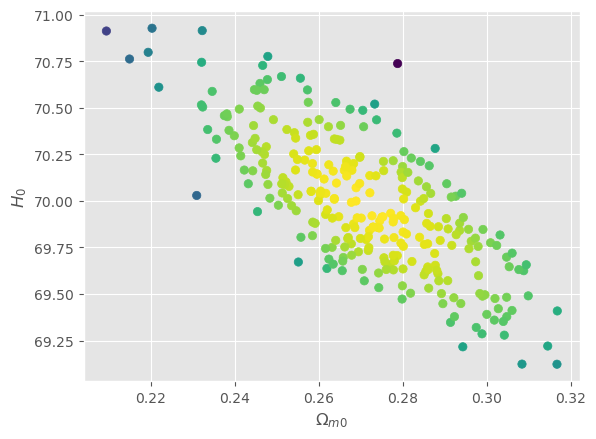

In [27]:
A = np.array(cadena_lcdm)
like = np.exp(-A[:,3]/np.min(A[:,3]))
plt.figure()
plt.scatter(A[:,0],A[:,2], c=like,)
plt.xlabel('$\Omega_{m0}$')
plt.ylabel('$H_0$')
plt.grid(True)

In [28]:
dic = {'Omo':A[:,0],'Ol':A[:,1],'H0':A[:,2],'like':A[:,3]}

In [29]:
df2 = pd.DataFrame(dic)
df2

,Omo,Ol,H0,like
0,0.254151,0.745764,70.366391,-271.686761
1,0.251270,0.748645,70.042660,-271.996514
2,0.246596,0.753319,70.203314,-271.979261
3,0.234570,0.765345,70.588126,-272.920261
4,0.257276,0.742639,70.596002,-272.937828
...,...,...,...,...
282,0.283032,0.716883,69.963398,-271.459277
283,0.295656,0.704259,69.847558,-272.115717
284,0.292714,0.707201,69.818652,-271.794436
285,0.275239,0.724676,69.914938,-271.165593


In [ ]:
#df2.to_csv('DatosCadenaDeMarkov.csv')

In [ ]:
#df2 = pd.concat([df1[['Omo','Ol','H0']],pd.DataFrame(like)],axis=1)

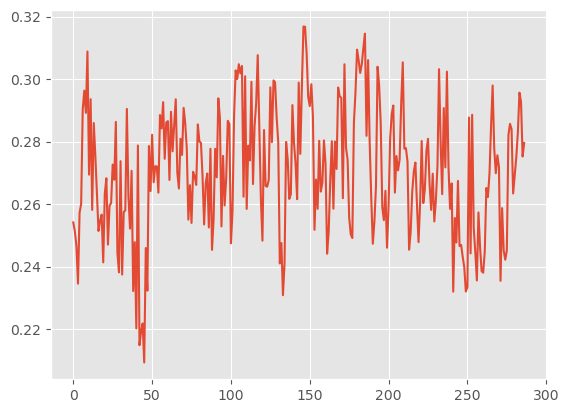

In [30]:
plt.plot(df2['Omo'])

<Axes: xlabel='H0', ylabel='Count'>

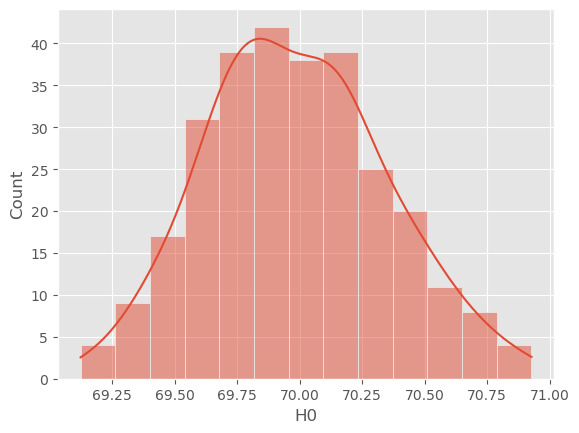

In [31]:
sns.histplot(df2['H0'],kde=True)

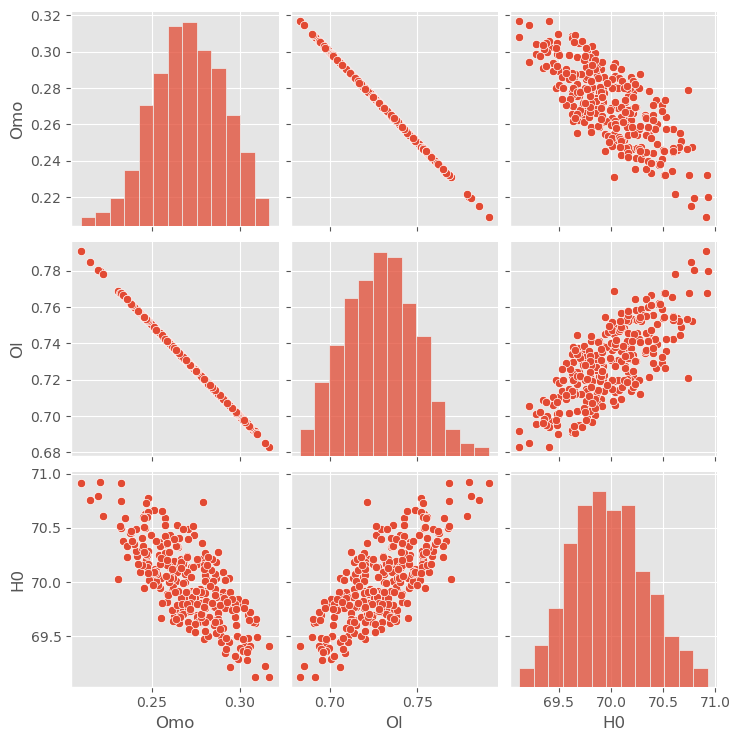

In [32]:
sns.pairplot(df2[['Omo','Ol','H0']],diag_kind='hist')#hue=0,diag_kind='hist')

In [ ]:
df2['Omega_l$'].sum()

np.float64(1886.623380130583)